# Instruções

1. Resolva todos os exercícios abaixo.
2. Salve uma cópia desse notebook em um repositório no GitHub.
3. Envie o link do repositório criado para o professor.
4. Envie um áudio curto ao professor explicando cada solução criada por você.

#1. Segmentação de Imagens com K-Means

Quando falamos de segmentação de imagens, dizemos que vamos localizar segmentos das imagens. Um algoritmo que realiza essa tarefa é o K-Means.

No vídeo abaixo, eu mostro como usar esse algoritmo para fazer quantização de imagens, ou seja, representar as cores originais em menos quantidades.

Dito isso, assista o vídeo abaixo e implemente um algoritmo que transforma qualquer imagem em um gráfico para jogo 8 bits. Assim, pegue uma imagem e gere ela novamente com apenas 256 cores usando o K-means.

<a href="https://www.youtube.com/watch?v=iHlve4t5z-0"><img src="https://img.youtube.com/vi/iHlve4t5z-0/mqdefault.jpg"/></a>

OBS: Se interessar, discuto o algoritmo K-means em mais detalhes nos vídeos abaixo.

<a href="https://www.youtube.com/watch?v=2hsMErlQtcI"><img src="https://img.youtube.com/vi/2hsMErlQtcI/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=p2twwtegYkU"><img src="https://img.youtube.com/vi/p2twwtegYkU/mqdefault.jpg"/></a>

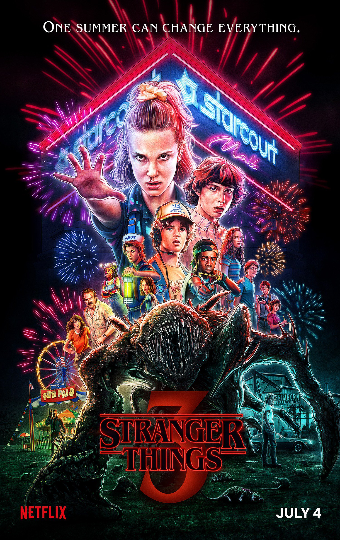

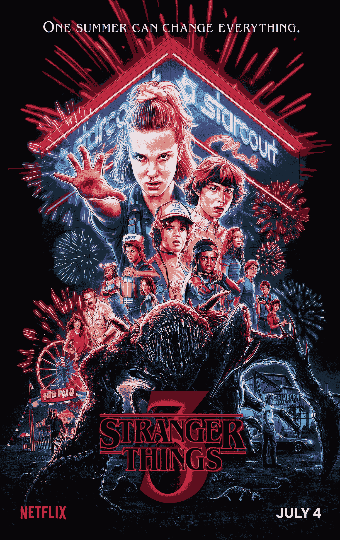

In [ ]:
# Resolução

from google.colab.patches import cv2_imshow
import cv2
import numpy as np

img = cv2.imread("/content/stranger-things.jpg")
Z = img.reshape((-1, 3)) # converter a imagem pro formato do kmeans mudando as dimensões, não sei a largura = -1, coluna = 3
Z = np.float32(Z) # converte para float pois o kmeans do opencv não trabalha com inteiro

# criterios para encerrar o kmeans: um dos dois acontecendo, encerra
criterio = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 40, 0.1) # EPS demarca o quão diferente estão os conjuntos, proximo de 0 = kmeans rigido
K = 8 # quantidade de cores para transformação

_, labels, centroides = cv2.kmeans(Z, K, None, criterio, 10, cv2.KMEANS_RANDOM_CENTERS) # labels = qual cor vai receber, centroides = media da cor

centroides = np.uint8(centroides) # converter de float para inteiro
imgColorCentroides = centroides[labels.flatten()] # aplico as cores na imagem de acordo com o pixel, vira um vetor com os pixels aplicados na "gaveta" 
imgFinal = imgColorCentroides.reshape((img.shape))

img = cv2.resize(img, (340, 540))
cv2_imshow(img)
imgFinal = cv2.resize(imgFinal, (340, 540))
cv2_imshow(imgFinal)



#2. Segmentação usando o algoritmo GrabCut

Quando o assunto é obter o segmento exato que contém um objeto, o algoritmo GrabCut é excelente.

Nos vídeos abaixos, há exemplos de sua implementação. 

<a href="https://www.youtube.com/watch?v=HBp6vQXFQgc"><img src="https://img.youtube.com/vi/HBp6vQXFQgc/mqdefault.jpg"/></a>
<a href="https://www.youtube.com/watch?v=DyRfAIQfVug"><img src="https://img.youtube.com/vi/DyRfAIQfVug/mqdefault.jpg"/></a>

Baseado nisso e nos conhecimentos anteriores, crie um algoritmo que segmente sua imagem e adicione por cima do fundo com efeito de borramento, usando um dos filtros explicados em lições passadas.

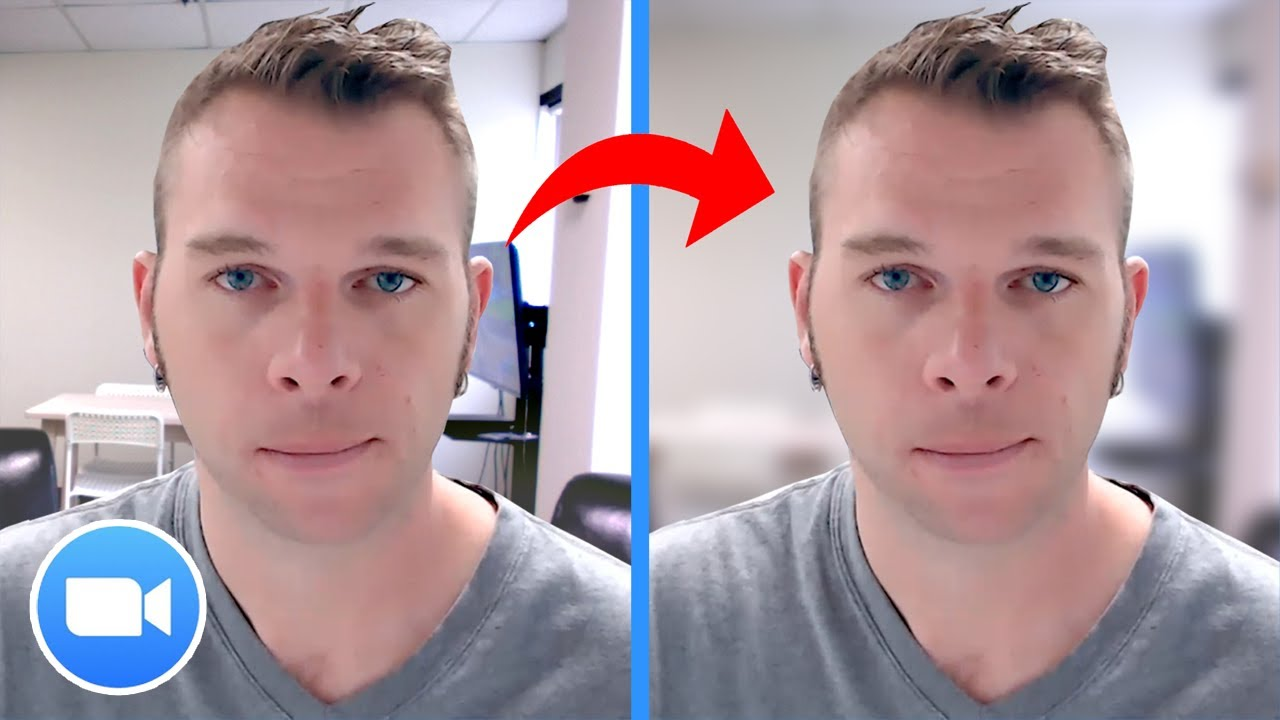

In [ ]:
# Resolução

from tkinter import *
from tkinter import filedialog as tkFileDialog
from PIL import ImageTk
from PIL import Image
import cv2
import numpy as np
from matplotlib import pyplot as plt

# cria uma classe herdeira de Frame
class GrabCutGUI(Frame):
  def __init__(self, master = None):
    Frame.__init__(self, master) # super()
    self.iniciaUI() # inicia a interface gráfica

  def iniciaUI(self):
    self.master.title("Janela da Imagem Segmentada")

    self.computaAcoesDoMouse() # computa ações do mouse

    self.pack() # organiza os componentes e prepara para exibição

    self.imagem = self.carregaImagemParaExibir()

    self.canvas = Canvas(self.master, width = self.imagem.width(), height = self.imagem.height(), cursor = "cross") # cria o canvas que receberá a imagem
    self.canvas.create_image(0, 0, anchor = NW, image = self.imagem) # desenha no canvas a imagem carregada, anchor = posição cardinal
    self.canvas.image = self.imagem # resolvendo o garbage collector
    
    self.canvas.pack()

  def computaAcoesDoMouse(self):
    self.startX = None
    self.startY = None
    self.rect = None
    self.rectangleReady = False

    self.master.bind("<ButtonPress-1>", self.callbackBotaoPressionado) # força um evento associado ao botão esquedo do mouse
    self.master.bind("<B1-Motion>", self.callbackBotaoPressionadoEmMovimento) # evento enquanto move o mouse pressionando o botão esquerdo
    self.master.bind("<ButtonRelease-1>", self.callbackBotaoSolto) # evento quando soltar o botão do mouse
    
  def callbackBotaoSolto(self, event):
    if self.rectangleReady:
      # criar nova janela filha da principal
      windowGrabcut = Toplevel(self.master)
      windowGrabcut.wm_title("Segmentation")
      windowGrabcut.minsize(width = self.imagem.width(), height = self.imagem.height())

      # criar canvas para a nova janela
      canvasGrabcut = Canvas(windowGrabcut, width = self.imagem.width(), height = self.imagem.height())
      canvasGrabcut.pack()

      # aplicar grabcut na imagem
      mask = np.zeros(self.imagemOpenCV.shape[:2], np.uint8) # 0 = fundo, 1 = objeto, 2 = provavelmente fundo, 3 = provavelmente objeto
      rectGcut = (int(self.startX), int(self.startY), int(event.x - self.startX), int(event.y - self.startY))
      fundoModel = np.zeros((1,65), np.float64)
      objModel = np.zeros((1,65), np.float64)

      # invocar o grabcut
      cv2.grabCut(self.imagemOpenCV, mask, rectGcut, fundoModel, objModel, 5, cv2.GC_INIT_WITH_RECT)

      # verifica as posições
      maskFinal = np.where((mask == 2) | (mask == 0), 0, 1).astype('uint8')

      
      # transformando as posições da matriz em um vetor 3d (estrategia pro fundo ficar preto)
      #imgFinal = self.imagemOpenCV * maskFinal[:,:,np.newaxis]

##      # transforma o fundo preto em branco
##      for x in range(0, self.imagemOpenCV.shape[1]):
##        for y in range(0, self.imagemOpenCV.shape[0]):
##          if(maskFinal[y][x] == 0):
##            imgFinal[y][x][0] = imgFinal[y][x][1] = imgFinal[y][x][2] = 255
##
##      # converter de opencv pra Tkinter
##      imgFinal = cv2.cvtColor(imgFinal, cv2.COLOR_BGR2RGB)
##      imgFinal = Image.fromarray(imgFinal)
##      imgFinal = ImageTk.PhotoImage(imgFinal)
##
##      
##      # inserir a imagem segmentada no novo canvas
##      canvasGrabcut.create_image(0, 0, anchor = NW, image = imgFinal)
##      canvasGrabcut.image = imgFinal  


      
  def callbackBotaoPressionadoEmMovimento(self, event):
    # novas posições de X e Y
    currentX = self.canvas.canvasx(event.x)
    currentY = self.canvas.canvasy(event.y)

    # atualiza o retângulo a ser desenhado
    self.canvas.coords(self.rect, self.startX, self.startY, currentX, currentY)

    # verifica se existe retangulo
    self.rectangleReady = True

  def callbackBotaoPressionado(self, event):
    self.startX = self.canvas.canvasx(event.x) # converte o X do frame para o X do canvas e captura a posição do eixo X
    self.startY = self.canvas.canvasx(event.y) # converte o YX do frame para o Y do canvas e captura a posição do eixo Y

    # se não existir o retângulo, cria
    if not self.rect:
      self.rect = self.canvas.create_rectangle(0, 0, 0, 0, outline = 'green')

  def carregaImagemParaExibir(self): 
    caminhoDaImagem = tkFileDialog.askopenfilename() # popup para escolher a imagem

    if(caminhoDaImagem != 0):
      self.imagemOpenCV = cv2.imread(caminhoDaImagem)
      image = cv2.cvtColor(self.imagemOpenCV, cv2.COLOR_BGR2RGB)  # converte de opencv para o formato PhotoImage que o Tkinter trabalha
      image = Image.fromarray(image) # converte de opencv para PIL
      image = ImageTk.PhotoImage(image) # converte de PIL para PhotoImage

      return image

def main():
  root = Tk() # inicializa a Tkinter com um objeto raíz
  appcut = GrabCutGUI(master = root) # cria a aplicação e passa root para o construtor de Frame
  appcut.mainloop() # cria o loop do programa

main()


#3. Comece a implementar o trabalho final

Apresente um código com o início do desenvolvimento de seu trabalho final. Explique no áudio o que você fez e como funciona.

[Repositório do GitHub com o Projeto Final
](https://github.com/rayanneblima/melanoma-CNN)

